Maxime BLANCHON

#### *Programmation sur Grille de Calcul - Générateurs de Variables Aléatoires*

# TP2 - Lois de probabilité

Nous avons vu dans le TP1 que nous pouvons implémenter des générateurs capables de produire des variables pseudo-aléatoires  indépendantes et identiquement distribuées (iid) sur l'intervalle [0, 1].

Cependant, comment peut-on faire pour générer des variables aléatoires de distributions différentes ? C'est ce que l'on va voir dans ce TP.

### Table des matières

* [I - Présentation des différentes méthodes](#presentation)
    * [1 - Méthode d'inversion](#inversion)
    * [2 - Théorème Central Limite](#theoreme_central_limite)
    * [3 - Méthode de Box et Muller](#box_muller)
    * [4 - Méthode du rejet](#rejet)
        * [a - Enveloppe de Cauchy](#cauchy)
        * [b - Enveloppe de Laplace](#laplace)
* [II - Comparaison des différentes méthodes de génération d'une loi normale](#comparaison)
    * [1 - Test d'équiprobabilité](#equiproba)
    * [2 - Test de Student](#student)
    * [3 - Test de Shapiro-Wilk](#shapiro_wilk)
    * [4 - Test de Lilliefors](#lilliefors)
    * [5 - Test d'Anderson Darling](#anderson_darling)
* [III - Cas particuliers : exemple de la  Loi de Poisson](#poisson)

##### Import des bibliothèques

In [1]:
import random
from math import sqrt
from statistics import mean
from typing import List, Callable

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.special import erfinv
from scipy.stats import kurtosis, skew, ttest_ind, shapiro, anderson
from statsmodels.graphics.gofplots import qqplot_2samples 
from statsmodels.stats.diagnostic import lilliefors
from math import exp, tan, e, log, pi

##### Fonctions utilitaires

In [2]:
# Implémentation de runif, un générateur de nombres pseudo-aléatoires iid sur l'intervalle [low, high]
def runif(n: int, low: float = 0, high: float = 1) -> np.ndarray:
    return np.array(np.random.uniform(low=low, high=high, size=n))

## I - Présentation des différentes méthodes<a name="presentation"></a>

### 1 - Méthode d'inversion<a name="inversion"></a>

Pour simuler la loi normale, nous allons utiliser la méthode de la loi inverse. Pour ce faire, on dispose de la fonction ``runif()``, un générateur de nombres pseudo-aléatoires iid dans l’intervalle $[0, 1]$ (implémenté ci-dessus).

Pour simuler la loi normale $N(0,1)$, nous devons utiliser l'inverse de sa fonction de répartition qui se calcule avec $erf^-1$ est qui est définie comme suit :

$$\large \blacksquare^{-1} (u) = y = \sqrt{2} erf^{-1} (2u - 1)$$

Voici l'implémentation de la méthode en Python :

In [3]:
def loi_normale_rep_inv(n: int) -> np.ndarray:
    x = runif(n)
    return sqrt(2) * erfinv(2 * x - 1)

In [4]:
# *** fonctions pour plot les distributions ***
def inline_qqplot(func: Callable, lengths: List[int], title: str) -> None:
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))
    
    for index, length in enumerate(lengths):
        x = sm.ProbPlot(func(length))
        y = sm.ProbPlot(func(length))
        qqplot_2samples(x, y, line="45", ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()


def inline_distplot(func: Callable, lengths: List[int], title: str) -> None:
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))

    for index, length in enumerate(lengths):
        sns.distplot(func(length), ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()

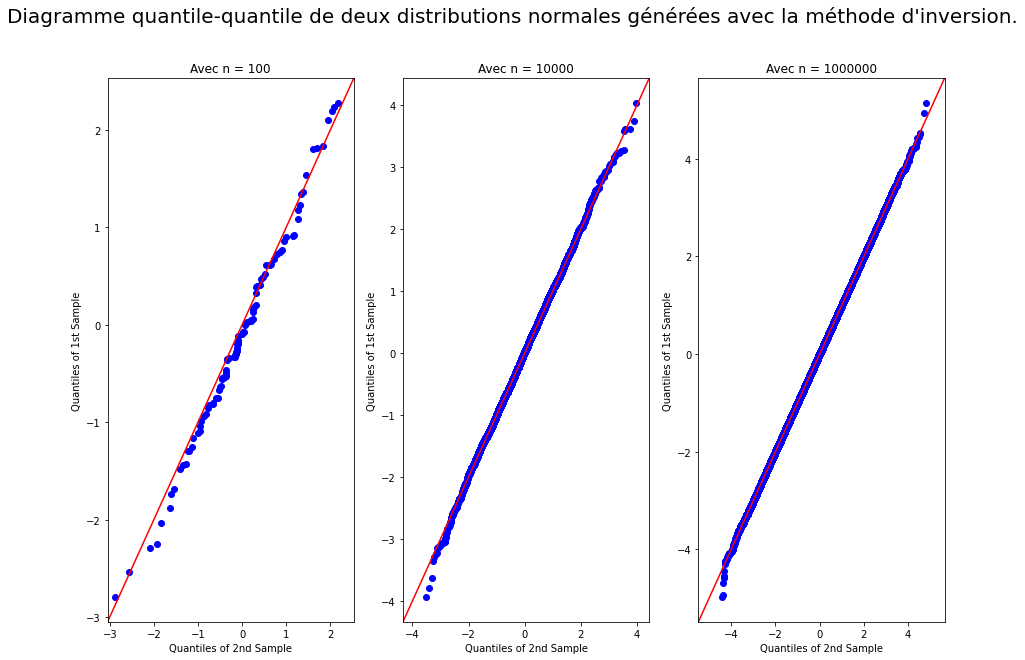

In [5]:
inline_qqplot(loi_normale_rep_inv, [100, 10_000, 1_000_000],
              'Diagramme quantile-quantile de deux distributions normales générées avec la méthode d\'inversion.')

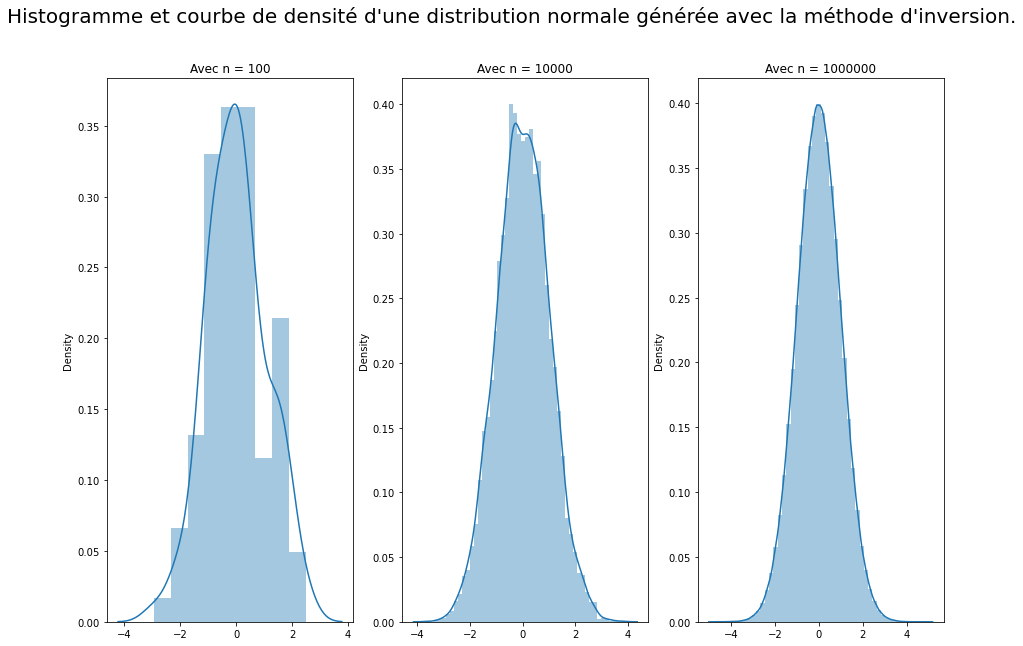

In [53]:
inline_distplot(loi_normale_rep_inv, [100, 10_000, 1_000_000],
                'Histogramme et courbe de densité d\'une distribution normale générée avec la méthode d\'inversion.')

### 2 - Théorème Central Limite<a name="theoreme_central_limite"></a>

Une application immédiate du Théorème Central Limite est la génération de variables aléatoires normales via une méthode très simple.

Partant de $n$ variables aléatoires $X_i$ de loi uniforme $U_{[0,1]}$, on peut générer une variable
aléatoire $Y$ ayant une loi normale de valeur moyenne $\bar{Y}$ et d'écart-type $\sigma_Y$ par la relation :

$$\large Y = \frac{\sum \limits_{i=1}^n (X_i) - \frac{n} {2}} {\sqrt{\frac{n} {12}}}$$

Voici l'implémentation de la méthode en Python :

In [7]:
def loi_normale_centrale_limite(n: int) -> np.ndarray:
    vect = []
    for i in range(n):
        x = runif(n)
        vect.append((sum(x) - n / 2) / sqrt(n / 12))
    return np.array(vect)

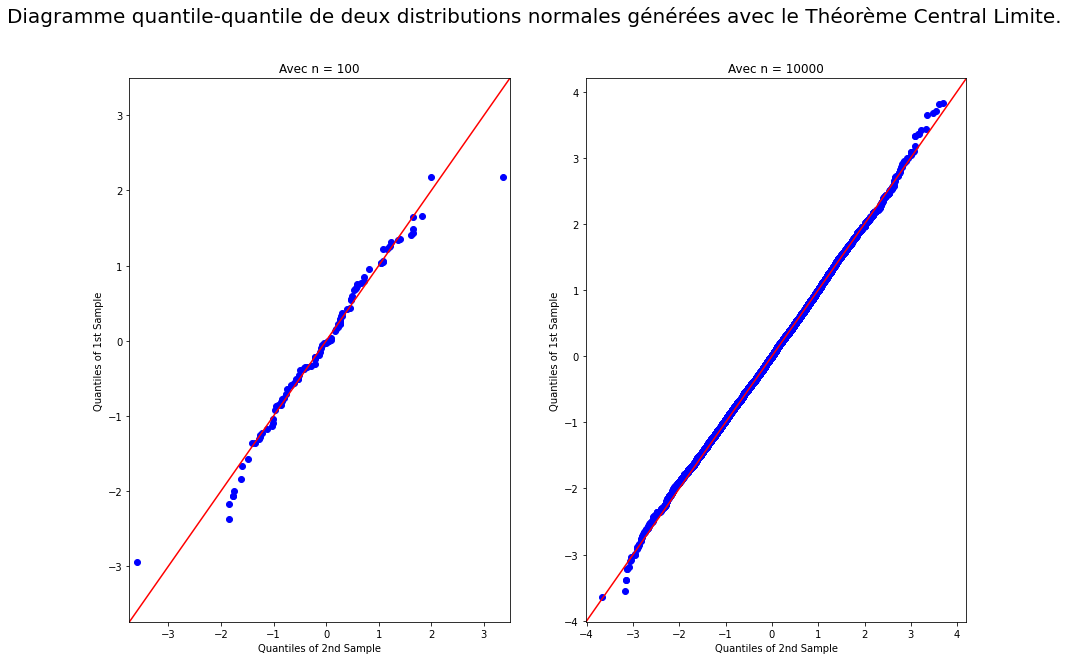

In [8]:
inline_qqplot(loi_normale_centrale_limite, [100, 10_000], 
              'Diagramme quantile-quantile de deux distributions normales générées avec le Théorème Central Limite.')

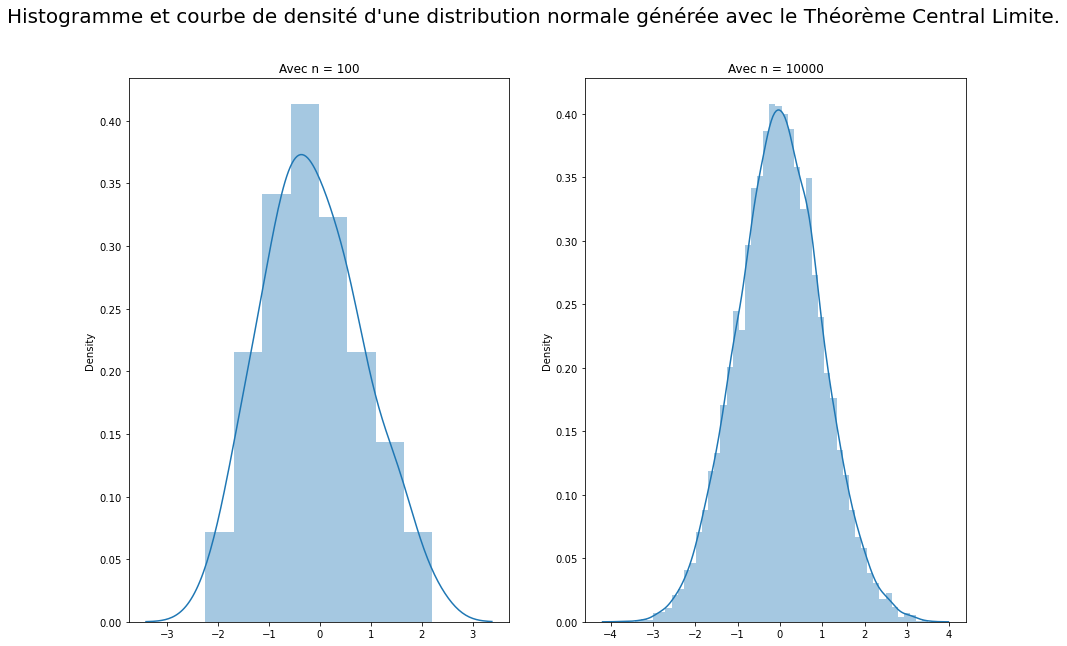

In [56]:
inline_distplot(loi_normale_centrale_limite, [100, 10_000],
                'Histogramme et courbe de densité d\'une distribution normale générée avec le Théorème Central Limite.')

### 3 - Méthode de Box et Muller<a name="box_muller"></a>

La méthode de Box et Muller permet de générer un $2n$-échantillon de la loi $N(0, 1)$ à partir d’un générateur de la loi uniforme. Si $U1$ et $U2$ sont indépendantes de loi uniforme sur $]0, 1[$, alors le couple suivant est formé de variables gaussiennes indépendantes centrées de variance 1:

$$\large {Y_0} = \sqrt {-2ln {U_1}} \cos({2 \pi {U_2}}) $$

$$\large {Y_1} = \sqrt {-2ln {U_1}} \sin({2 \pi {U_2}}) $$

La simulation de deux variables indépendantes de loi uniforme conduit à la simulation de deux variables aléatoires gaussiennes standard indépendantes.

Voici l'implémentation de la méthode en Python :

In [10]:
def box_muller(n: int):
    x0 = runif(n)
    x1 = runif(n)
    y0 = np.sqrt(-2 * np.log(x0)) * np.cos(2 * pi * x1)
    y1 = np.sqrt(-2 * np.log(x0)) * np.sin(2 * pi * x1)
    return y0, y1

In [11]:
# *** fonctions pour plot la méthode Box & Muller ***
def inline_qqplot_bm(lengths: List[int]) -> None:
    title = 'Diagramme quantile-quantile de deux distributions normales générées avec la méthode de Box et Muller.'
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))

    for index, length in enumerate(lengths):
        y0, y1 = box_muller(length)
        x = sm.ProbPlot(y0)
        y = sm.ProbPlot(y1)
        qqplot_2samples(x, y, line="45", ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()


def inline_distplot_bm(lengths: List[int]) -> None:
    title =  'Histogramme et courbe de densité d\'une distribution normale générée avec la méthode de Box et Muller.'
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))

    for index, length in enumerate(lengths):
        y0, y1 = box_muller(length)
        sns.distplot(y0, ax=axes[index])
        sns.distplot(y1, ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.legend(labels=['Y_0', 'Y_1'])
    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()
# ***

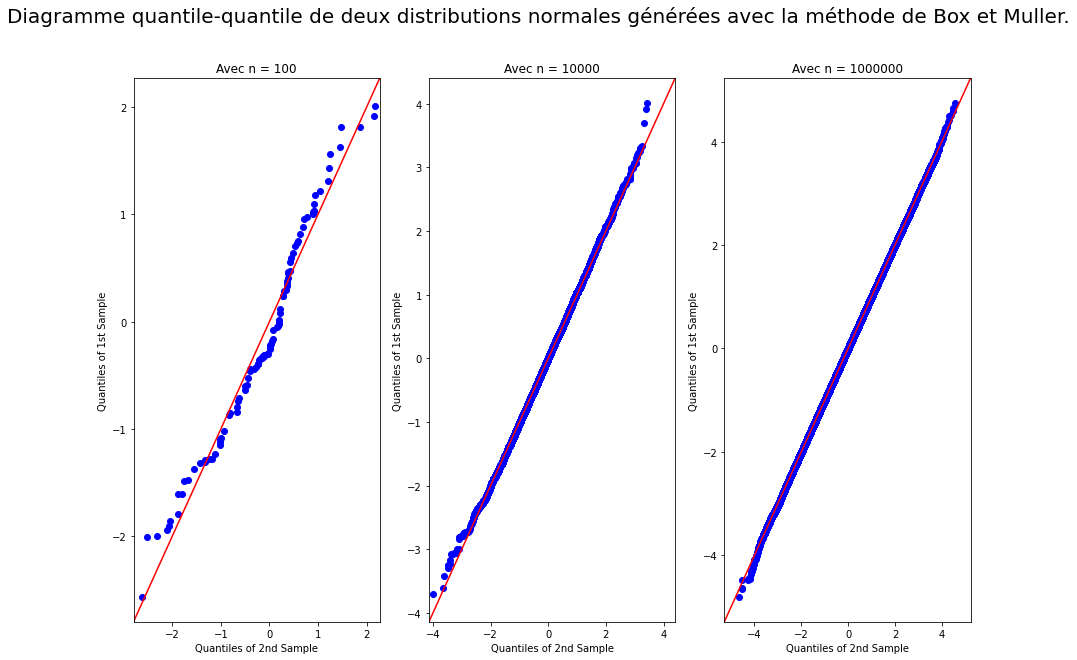

In [12]:
inline_qqplot_bm([100, 10_000, 1_000_000])

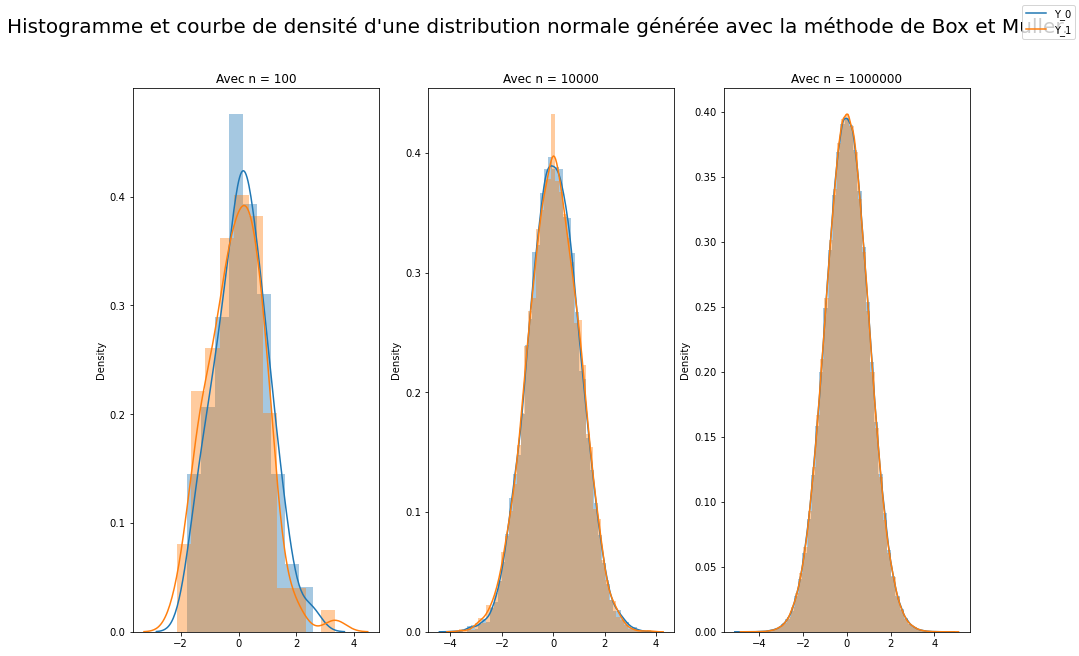

In [41]:
inline_distplot_bm([100, 10_000, 1_000_000])

### 4 - Méthode du rejet<a name="rejet"></a>

La méthode du rejet est une méthode de simulation utilisée lorsqu'il est compliqué de simuler des observations de la fonction désirée mais simple de le faire pour une fonction enveloppante.

Dans notre cas, nous voulons simuler des observations de la loi normale mais il n'existe pas de formule simple pour la fonction de répartition de cette loi. Pour ce faire, on utilise une fonction enveloppante de la loi normale. On dispose des enveloppes de Cauchy et de Laplace, définies ci-après. Ces deux enveloppes utilisent la fonction de densité de probabilité de la loi normale centrée réduite (que l'on veut envelopper), implémentée ci-dessous en Python :

In [14]:
def gaussian_density(x):
    a = 1 / (sqrt(2) * pi)
    b = exp(-x * x / 2)
    return a * b

#### a - Enveloppe de Cauchy<a name="cauchy"></a>

L'enveloppe de Cauchy est définie de la façon suivante :

$$\large \forall x\in \mathbb{R}, \frac {1} {\sqrt {2 \pi}} e^{\frac{-x^2} {2}} ≤ \sqrt{\frac {2 \pi} {e}}\frac{1} {\pi}  \frac{1} {1 + x^2}$$

Voici son implémentation en Python :

In [15]:
def cauchy(n: int) -> np.ndarray:
    res = [0 for _ in range(n)]
    c = sqrt(2 * pi / e)

    for i in range(n):
        u1 = random.uniform(0, 1)
        x = tan(pi * (u1 - 1 / 2))
        u2 = random.uniform(0, 1)
        res[i] = x

        while c * u2 / (pi * (1 + x * x)) > gaussian_density(x):
            u1 = random.uniform(0, 1)
            x = tan(pi * (u1 - 1 / 2))
            u2 = random.uniform(0, 1)
            res[i] = x

    return np.array(res)

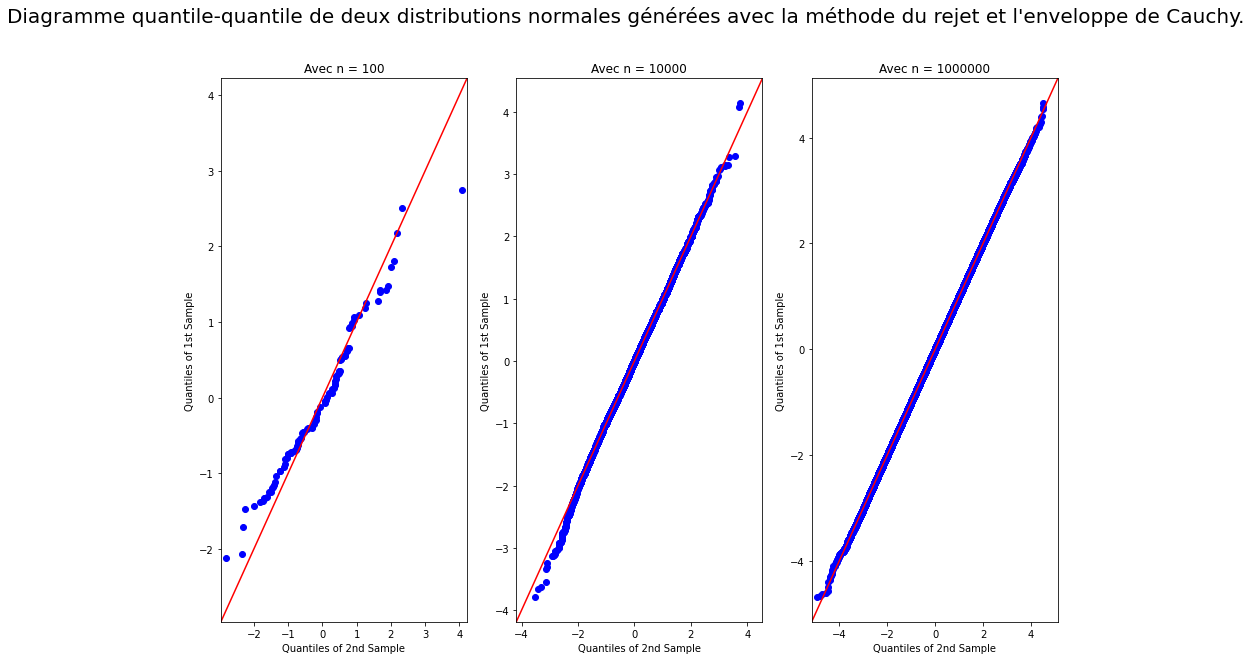

In [16]:
inline_qqplot(cauchy, [100, 10_000, 1_000_000],
              'Diagramme quantile-quantile de deux distributions normales générées avec la méthode du rejet et l\'enveloppe de Cauchy.')

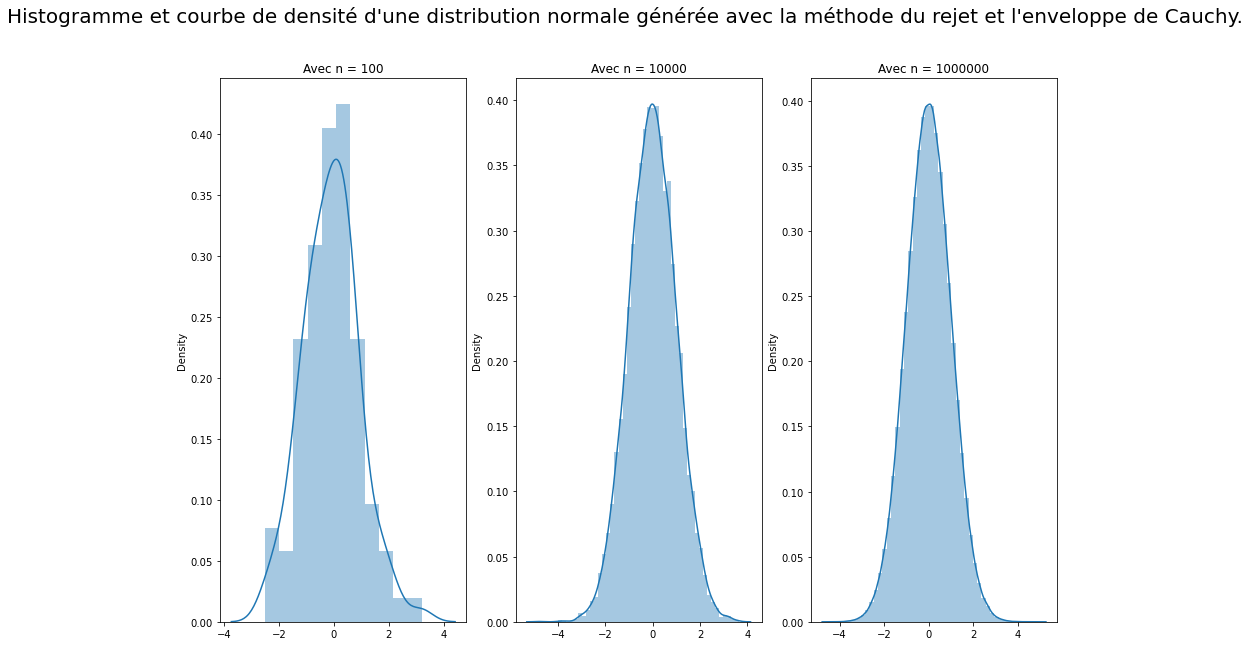

In [17]:
inline_distplot(cauchy, [100, 10_000, 1_000_000],
                'Histogramme et courbe de densité d\'une distribution normale générée avec la méthode du rejet et l\'enveloppe de Cauchy.')

#### b - Enveloppe de Laplace<a name="laplace"></a>

L'enveloppe de Laplace est définie de la façon suivante :

$$\large \forall x\in \mathbb{R}, \frac {1} {\sqrt {2 \pi}} e^{\frac{-x^2} {2}} ≤ 2 \sqrt{\frac {e} {2 \pi}} \frac{1} {2} e^{- |x|}$$

Voici son implémentation en Python :

In [18]:
def laplace(n: int) -> np.ndarray:
    res = [0 for _ in range(n)]
    c = 2 * (sqrt(e / 2 * pi))
    b = 1
    mu = 0

    for i in range(n):
        u1 = random.uniform(0, 1)
        x = mu - b * np.sign(u1 - 0.5) * log(1 - 2 * abs(u1 - 0.5))
        u2 = random.uniform(0, 1)
        res[i] = x

        while c * u2 * 1 / 2 * exp(-abs(x)) > gaussian_density(x):
            u1 = random.uniform(0, 1)
            x = mu - b * np.sign(u1 - 0.5) * log(1 - 2 * abs(u1 - 0.5))
            u2 = random.uniform(0, 1)
            res[i] = x

    return np.array(res)

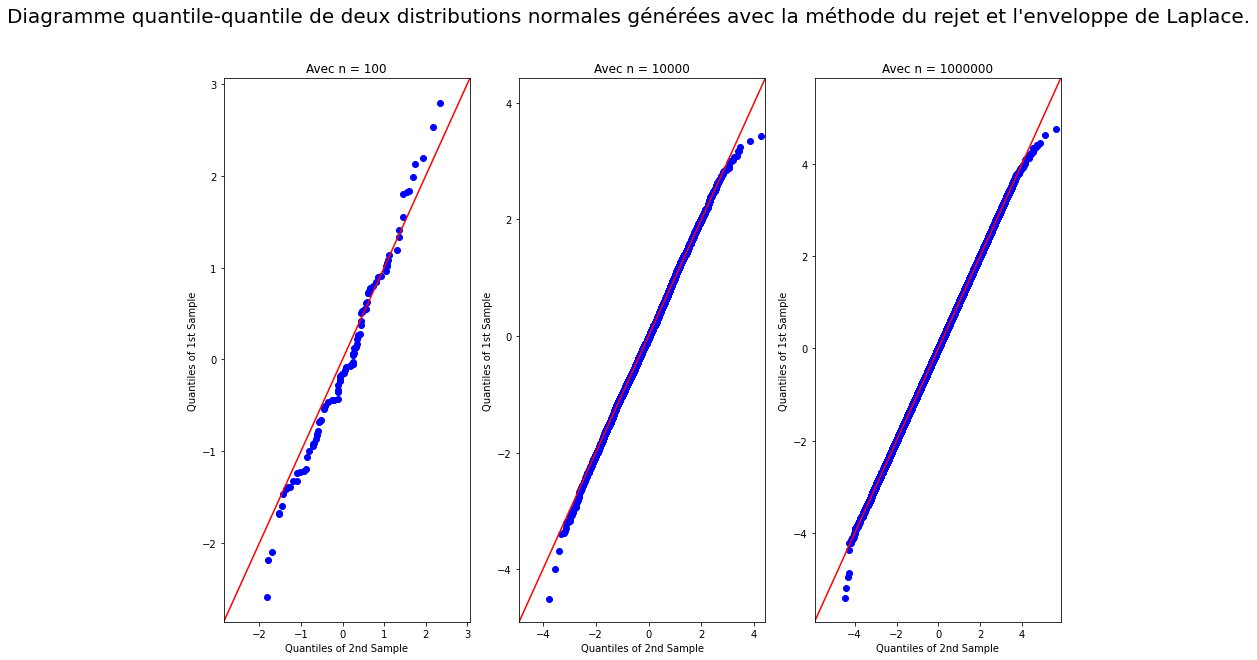

In [19]:
inline_qqplot(laplace, [100, 10_000, 1_000_000],
              'Diagramme quantile-quantile de deux distributions normales générées avec la méthode du rejet et l\'enveloppe de Laplace.')

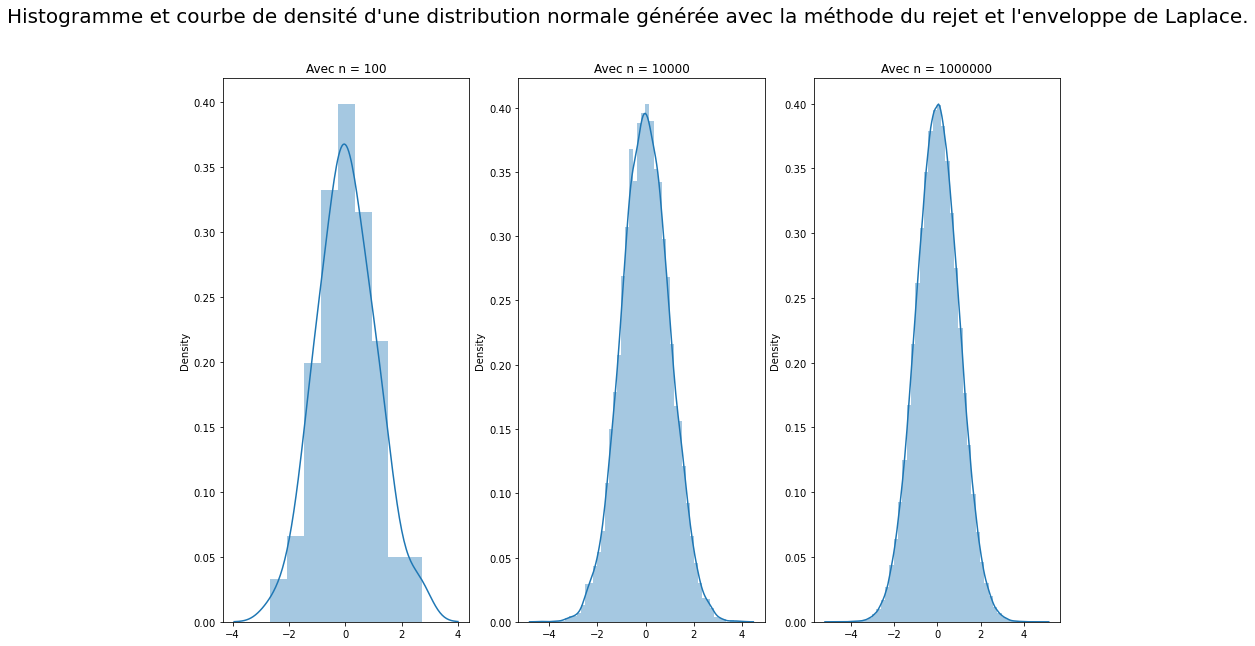

In [20]:
inline_distplot(laplace, [100, 10_000, 1_000_000],
                'Histogramme et courbe de densité d\'une distribution normale générée avec la méthode du rejet et l\'enveloppe de Laplace.')

## II - Comparaison des différentes méthodes de génération d'une loi normale<a name="comparaison"></a>

### 1 - Test d'équiprobabilité<a name="equiproba"></a>

In [42]:
NAMES = ['Loi Normale Inverse', 'Loi Normale Centrale Limite', 'Box et Muller (Y_0)', 'Box et Muller (Y_1)', 'Enveloppe de Cauchy',
         'Enveloppe de Laplace']
n = 10_000
y0, y1 = box_muller(n)
distributions = [loi_normale_rep_inv(n), loi_normale_centrale_limite(n), y0, y1, cauchy(n), laplace(n)]

rows = {'Mean value': [mean(sublist) for sublist in distributions],
        'Quartile 25%': [np.percentile(sublist, 25) for sublist in distributions],
        'Quartile 50%': [np.percentile(sublist, 50) for sublist in distributions],
        'Quartile 75%': [np.percentile(sublist, 75) for sublist in distributions],
        'Variance': [np.var(sublist) for sublist in distributions],
        'Kurtosis (normalised)': [kurtosis(sublist) for sublist in distributions],
        'Skewness': [skew(sublist) for sublist in distributions]}

data = pd.DataFrame.from_dict(rows, orient='index', columns=NAMES)
data['Valeur théorique'] = [0,  -0.675, 0,  0.675, 1, 0, 0]
data

,Loi Normale Inverse,Loi Normale Centrale Limite,Box et Muller (Y_0),Box et Muller (Y_1),Enveloppe de Cauchy,Enveloppe de Laplace,Valeur théorique
Mean value,-0.010251,-0.007517,-0.009121,0.004999,0.005734,0.018320,0.000
Quartile 25%,-0.683037,-0.686947,-0.689621,-0.660874,-0.683118,-0.650959,-0.675
Quartile 50%,-0.007195,-0.011432,-0.015876,0.006857,0.001311,0.013325,0.000
Quartile 75%,0.638432,0.660563,0.652969,0.668364,0.680852,0.690240,0.675
Variance,0.983948,1.001886,0.995854,0.992763,0.990247,1.008505,1.000
Kurtosis (normalised),0.012852,0.060144,-0.013739,0.011962,0.029090,0.100482,0.000
Skewness,0.006032,0.026470,0.040697,0.004141,0.037003,0.012248,0.000


On peut voir sur le tableau ci-dessus que les quartiles et les moments des distributions générées avec les différentes méthodes sont très proches des valeurs "théoriques" d'une loi normale.

### 2 - Test de Student<a name="student"></a>

On réalise un test de Student à 2 échantillons indépendants. Ce test va permettre de comparer la moyenne de deux populations indépendantes pour identifier une différence significative.

Dans notre cas, on veut comparer chaque distribution normale générée par les méthodes implémentées en Python précédemment avec celle générée par la fonction ``np.random.normal`` (intégrée à la bibliothèque numpy).

On a donc :

- **Hypothèse nulle H0** : la moyenne de la distribution est égale à la moyenne de ``np.random.normal``.
- **Hypothèse alternative Ha** : moyenne de la distribution n'est pas égale à la moyenne de ``np.random.normal``.

Ci-dessous, on réalise un test t bilatéral avec la fonction ``ttest_ind`` sur des échantillons de taille n = 10 000. On choisit un risque $\alpha$ = 0,05.

In [47]:
def student_test(samples: List[np.ndarray], samples_names: List[str], dist: np.ndarray, dist_name: str, alpha: float):
    for i, sample in enumerate(samples):
        statistic, p = ttest_ind(sample, dist)
        print(f'== {samples_names[i]} et {dist_name} ==\nt = {statistic}, pvalue = {p}')
        if (p > alpha):
            print("Les moyenne des distributions sont identiques (Acceptation de H0 et rejet de Ha)\n")
        else :
            print("Les moyenne des distributions sont différentes (Acception de Ha et rejet de H0)\n")

normal_dist = [np.random.normal(0, 1) for _ in range(n)]
student_test(distributions, NAMES, normal_dist, 'np.random.normal', 0.05)

== Loi Normale Inverse et np.random.normal ==
t = -1.0193363541828235, pvalue = 0.3080556417652607
Les moyenne des distributions sont identiques (Acceptation de H0 et rejet de Ha)

== Loi Normale Centrale Limite et np.random.normal ==
t = -0.8211825142979999, pvalue = 0.4115521039815342
Les moyenne des distributions sont identiques (Acceptation de H0 et rejet de Ha)

== Box et Muller (Y_0) et np.random.normal ==
t = -0.9361401889291138, pvalue = 0.3492123176335282
Les moyenne des distributions sont identiques (Acceptation de H0 et rejet de Ha)

== Box et Muller (Y_1) et np.random.normal ==
t = 0.06527137406769976, pvalue = 0.9479585863435795
Les moyenne des distributions sont identiques (Acceptation de H0 et rejet de Ha)

== Enveloppe de Cauchy et np.random.normal ==
t = 0.11756498312904472, pvalue = 0.9064135325645117
Les moyenne des distributions sont identiques (Acceptation de H0 et rejet de Ha)

== Enveloppe de Laplace et np.random.normal ==
t = 1.0068129892816389, pvalue = 0.31403

### 3 - Test de  Shapiro-Wilk<a name="shapiro_wilk"></a>

Le test de Shapiro-Wilk est un test permettant de savoir si une série de données suit une loi normale.

On a :

- **Hypothèse nulle H0** : l'échantillon suit la loi normale.
- **Hypothèse alternative Ha** : l'échantillon ne suit pas la loi normale.

Ci-dessous, on réalise le test de Shapiro-Wilk pour chaque distribution normale générée par les méthodes implémentées en Python précédemment sur des échantillons de taille n = 10 000. On choisit un risque $\alpha$ = 0,05.

In [48]:
def shapiro_wilk_test(samples: List[np.ndarray], samples_names: List[str], alpha: float):
    for i, sample in enumerate(samples):
        statistic, p = shapiro(sample)
        print(f'== {samples_names[i]}==\nstatistic = {statistic}, pvalue = {p}')
        if (p > alpha):
            print("L'échantillon suit la loi normale (Acceptation de H0 et rejet de Ha)\n")
        else :
            print("L'échantillon ne suit pas la loi normale (Acceptation de Ha et rejet de H0)\n")

shapiro_wilk_test(distributions, NAMES, 0.05)

== Loi Normale Inverse==
statistic = 0.9998420476913452, pvalue = 0.7399121522903442
L'échantillon suit la loi normale (Acceptation de H0 et rejet de Ha)

== Loi Normale Centrale Limite==
statistic = 0.9997495412826538, pvalue = 0.2773277461528778
L'échantillon suit la loi normale (Acceptation de H0 et rejet de Ha)

== Box et Muller (Y_0)==
statistic = 0.9997656941413879, pvalue = 0.34002068638801575
L'échantillon suit la loi normale (Acceptation de H0 et rejet de Ha)

== Box et Muller (Y_1)==
statistic = 0.9998781681060791, pvalue = 0.9096872210502625
L'échantillon suit la loi normale (Acceptation de H0 et rejet de Ha)

== Enveloppe de Cauchy==
statistic = 0.9997891187667847, pvalue = 0.44805043935775757
L'échantillon suit la loi normale (Acceptation de H0 et rejet de Ha)

== Enveloppe de Laplace==
statistic = 0.9997924566268921, pvalue = 0.4649866223335266
L'échantillon suit la loi normale (Acceptation de H0 et rejet de Ha)



### 4 - Test de Lilliefors<a name="lilliefors"></a>

Le test de Lilliefors est un test de normalité adapté du test de Kolmogorov-Smirnov. Il permet de tester l'hypothèse nulle que les données soient issues d'une loi normale quand ni l'espérance $\mu$ ni l'écart type $\sigma$ d'une loi normale ne sont connus.

On a :

- **Hypothèse nulle H0** : l'échantillon est issu d'une loi normale.
- **Hypothèse alternative Ha** : l'échantillon n'est pas issu d'une loi normale.

Ci-dessous, on réalise le test de Lilliefors pour chaque distribution normale générée par les méthodes implémentées en Python précédemment sur des échantillons de taille n = 10 000. On choisit un risque $\alpha$ = 0,05.

In [49]:
def lilliefors_test(samples: List[np.ndarray], samples_names: List[str], alpha: float):
    for i, sample in enumerate(samples):
        statistic, p = lilliefors(sample, dist='norm')
        print(f'== {samples_names[i]}==\nstatistic = {statistic}, pvalue = {p}')
        if (p > alpha):
            print("L'échantillon est issu d'une loi normale (Acceptation de H0 et rejet de Ha)\n")
        else :
            print("L'échantillon n'est pas issu d'une loi normale (Acceptation de Ha et rejet de H0)\n")

lilliefors_test(distributions, NAMES, 0.05)

== Loi Normale Inverse==
statistic = 0.007067776304839568, pvalue = 0.250008515508801
L'échantillon est issu d'une loi normale (Acceptation de H0 et rejet de Ha)

== Loi Normale Centrale Limite==
statistic = 0.006912487563442982, pvalue = 0.2867092738933895
L'échantillon est issu d'une loi normale (Acceptation de H0 et rejet de Ha)

== Box et Muller (Y_0)==
statistic = 0.005124827331813742, pvalue = 0.7511108575116345
L'échantillon est issu d'une loi normale (Acceptation de H0 et rejet de Ha)

== Box et Muller (Y_1)==
statistic = 0.005975760537533792, pvalue = 0.509725812877813
L'échantillon est issu d'une loi normale (Acceptation de H0 et rejet de Ha)

== Enveloppe de Cauchy==
statistic = 0.006395850543246762, pvalue = 0.40881065922390447
L'échantillon est issu d'une loi normale (Acceptation de H0 et rejet de Ha)

== Enveloppe de Laplace==
statistic = 0.006708438558638119, pvalue = 0.3349339755466392
L'échantillon est issu d'une loi normale (Acceptation de H0 et rejet de Ha)



### 5 - Test d'Anderson-Darling<a name="anderson_darling"></a>

Le test d'Anderson-Darling est un test de normalité de l'échantillon statistique. Il permet de détecter l'écart par rapport à la normalité des valeurs maximales et minimales d'une distribution.

Le test d'Anderson-Darling teste l'hypothèse nulle selon laquelle un échantillon est tiré d'une population qui suit une distribution particulière. Dans notre cas, la distribution particulière sera la loi normale.

On a :

- **Hypothèse nulle H0** : l'échantillon est tiré d'une population qui suit une distribution normale.
- **Hypothèse alternative Ha** : l'échantillon n'est pas tiré d'une population qui suit une distribution normale.

Ci-dessous, on réalise le test d'Anderson-Darling pour chaque distribution normale générée par les méthodes implémentées en Python précédemment sur des échantillons de taille n = 10 000.

In [50]:
def anderson_darling_test(samples: List[np.ndarray], samples_names: List[str]):
    for i, sample in enumerate(samples):
        result = anderson(sample, dist='norm')
        print(f'== {samples_names[i]}==\nstatistic = {result.statistic}')

        for i in range(len(result.critical_values)):
            if result.statistic > result.critical_values[i]:
                print(f'sl = {result.significance_level[i]} --> L\'échantillon n\'est pas tiré d\'une population qui suit une distribution normale (Acceptation de Ha et rejet de H0).')
            else:
                print(f'sl = {result.significance_level[i]} --> L\'échantillon est tiré d\'une population qui suit une distribution normale (Acceptation de H0 et rejet de Ha).')
        print()
                
anderson_darling_test(distributions, NAMES)

== Loi Normale Inverse==
statistic = 0.3257667546367884
sl = 15.0 --> L'échantillon est tiré d'une population qui suit une distribution normale (Acceptation de H0 et rejet de Ha).
sl = 10.0 --> L'échantillon est tiré d'une population qui suit une distribution normale (Acceptation de H0 et rejet de Ha).
sl = 5.0 --> L'échantillon est tiré d'une population qui suit une distribution normale (Acceptation de H0 et rejet de Ha).
sl = 2.5 --> L'échantillon est tiré d'une population qui suit une distribution normale (Acceptation de H0 et rejet de Ha).
sl = 1.0 --> L'échantillon est tiré d'une population qui suit une distribution normale (Acceptation de H0 et rejet de Ha).

== Loi Normale Centrale Limite==
statistic = 0.4469921729032649
sl = 15.0 --> L'échantillon est tiré d'une population qui suit une distribution normale (Acceptation de H0 et rejet de Ha).
sl = 10.0 --> L'échantillon est tiré d'une population qui suit une distribution normale (Acceptation de H0 et rejet de Ha).
sl = 5.0 --> L

## II - Cas particuliers : exemple de la  Loi de Poisson<a name="poisson"></a>

Pour générer des variables aléatoires à distribution de Poisson, on génère des variables exponentielles $E1, E2, …$ et on les additionne. Le plus petit nombre de variables exponentielles dont la somme dépasse 1 donne une variable aléatoire de Poisson. Autrement dit, si on définit $N$ comme le plus petit $n$ tel que :

$$\large \sum \limits_{k=1}^n E_k > 1 $$

alors $N$ est une variable aléatoire distribuée selon une loi de Poisson.

La génération de variables exponentielles se fait facilement en utilisant la méthode inverse. Pour $U(0, 1)$, la transformation :

$$\large E = \frac {− 1} {\lambda} ln(U) $$ 

donne une variable aléatoire exponentielle de moyenne $\frac {1} {\lambda}$. 

Voici l'implémentation de cette méthode en Python :

In [26]:
def poisson(lmbd: int, n: int) -> np.ndarray:
    dist = np.zeros(n)  # init

    for i in range(n):

        exp_sum = 0
        counter = -1

        while exp_sum < 1:
            exp_sum += -(1 / lmbd) * np.log(random.uniform(0, 1))
            counter += 1

        dist[i] = counter

    return dist

In [27]:
# *** fonctions pour plot la loi de poisson ***
def inline_qqplot_poisson(lmbd: int, lengths: List[int]) -> None:
    title = f'Diagramme quantile-quantile de deux distributions de Poisson (λ = {lmbd}) générées en utilisant des variables aléatoires exponentielles.'
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))

    for index, length in enumerate(lengths):
        x = sm.ProbPlot(poisson(lmbd, length))
        y = sm.ProbPlot(poisson(lmbd, length))
        qqplot_2samples(x, y, line="45", ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')

    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()


def inline_histplot_poisson(lmbd: int, lengths: List[int]) -> None:
    title = f'Histogramme et courbe de densité d\'une distribution de Poisson (λ = {lmbd}) générée en utilisant des variables aléatoires exponentielles.'
    fig, axes = plt.subplots(nrows=1, ncols=len(lengths))
    
    for index, length in enumerate(lengths):
        sns.histplot(poisson(lmbd, length), ax=axes[index])
        axes[index].title.set_text(f'Avec n = {length}')
        
    fig.set_size_inches(15, 10)
    plt.suptitle(title, fontsize=20, y=0.98)
    plt.show()
# ***

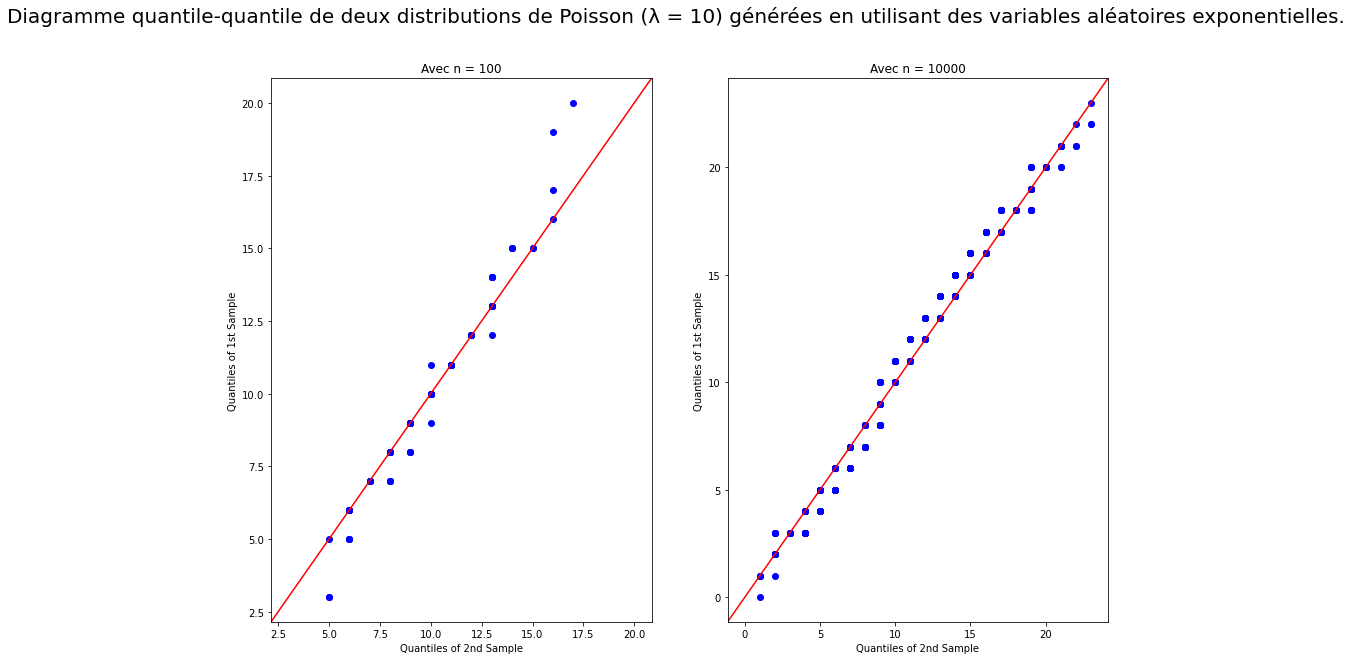

In [28]:
inline_qqplot_poisson(10, [100, 10_000])

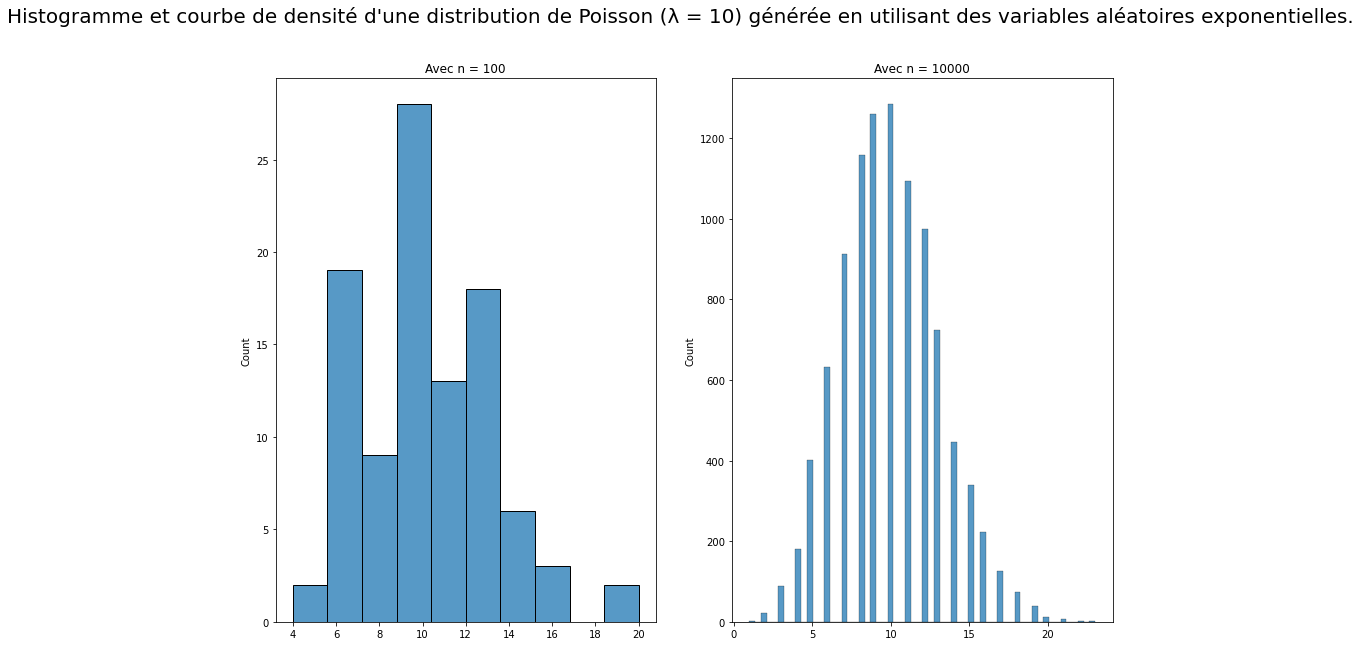

In [29]:
inline_histplot_poisson(10, [100, 10_000])

In [30]:
n = 10_000
lmbd = 10
dist = poisson(lmbd, n)

rows = {'Mean value': mean(dist),
        'Quartile 25%': np.percentile(dist, 25),
        'Quartile 50% ': np.percentile(dist, 50),
        'Quartile 75%': np.percentile(dist, 75),
        'Variance': np.var(dist),
        'Kurtosis (normalised)': kurtosis(dist),
        'Skewness': skew(dist)}
data = pd.DataFrame.from_dict(rows, orient='index', columns=[f'Poisson (λ = {lmbd})'])
data['Valeur théorique'] = [lmbd, 8, lmbd, 12, lmbd, 1/lmbd, 1/sqrt(lmbd)]
data

,Poisson (λ = 10),Valeur théorique
Mean value,9.990000,10.000000
Quartile 25%,8.000000,8.000000
Quartile 50%,10.000000,10.000000
Quartile 75%,12.000000,12.000000
Variance,9.937700,10.000000
Kurtosis (normalised),0.079213,0.100000
Skewness,0.340227,0.316228


On peut voir sur le tableau ci-dessus que les quartiles et les moments de la distribution générée avec l'approximation de la loi de Poisson sont très proches des valeurs "théoriques" de cette loi (pour $\lambda$ = 10).